In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-07-20 11:23:49.353164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 11:23:49.353292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 11:23:49.483885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Extract and Load Data

In [2]:
annotation_file_path = "/kaggle/input/flickr-logos-27-dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
annotationDF = pd.read_csv(annotation_file_path, 
                      sep="\s+", 
                      header=None, 
                      names=["image", "logo", "subset", "x1", "y1", "x2", "y2"])

<Figure size 1500x1000 with 0 Axes>

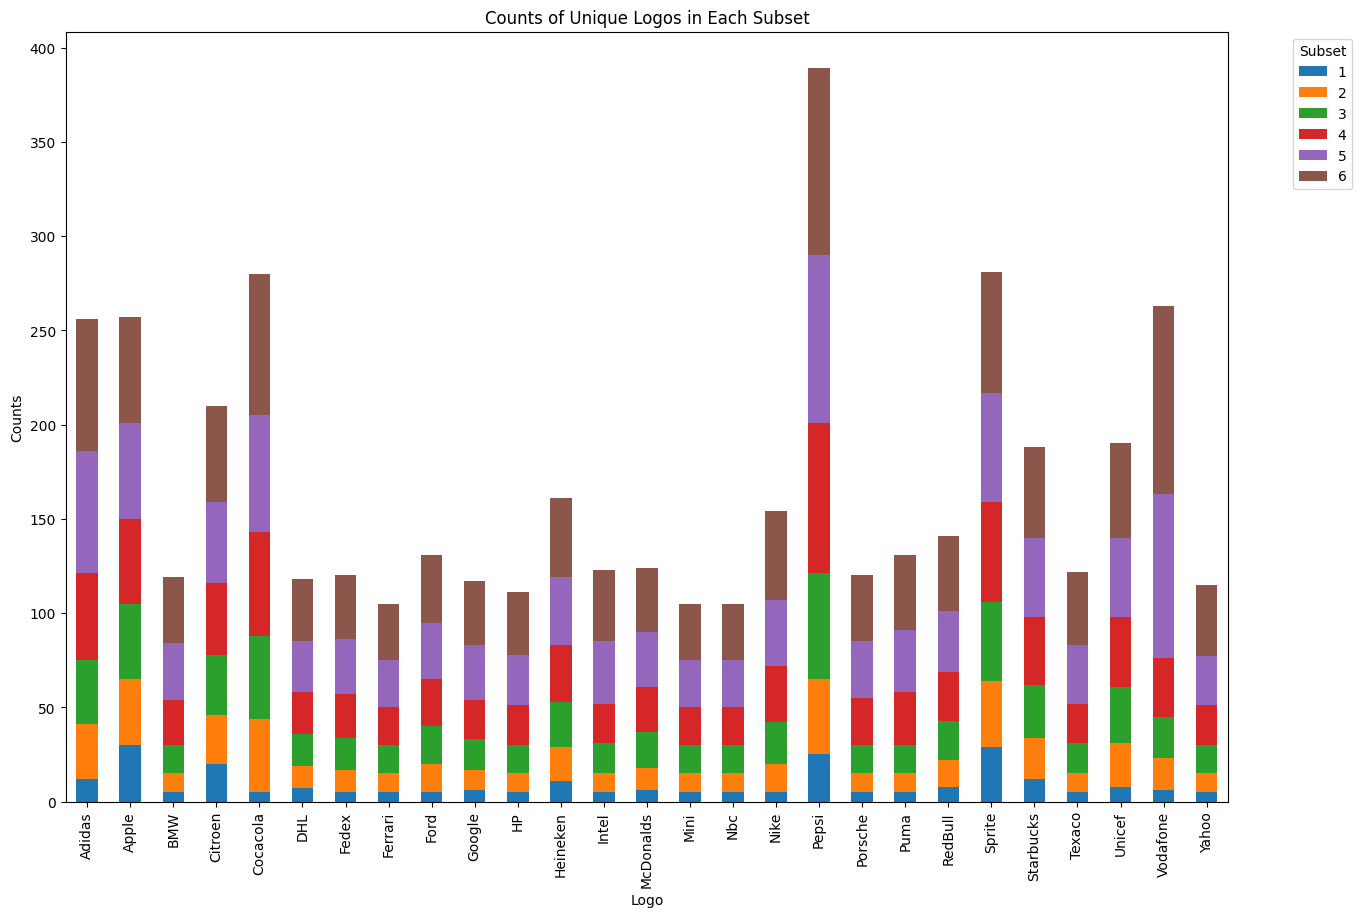

In [3]:
groupedDF = annotationDF.groupby(['logo', 'subset']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 10))
groupedDF.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Counts of Unique Logos in Each Subset')
plt.xlabel('Logo')
plt.ylabel('Counts')
plt.legend(title='Subset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Before Preprocessing

In [4]:
images_dir = "/kaggle/input/flickr-logos-27-dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images"
sample_images = []
sample_image_file = []

for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    sample_images.append(img)
    sample_image_file.append(image)

# Display the number of images and labels
print("Total images: {}".format(len(sample_images)))
print("Total labels: {}".format(len(sample_image_file)))

Total images: 1079
Total labels: 1079


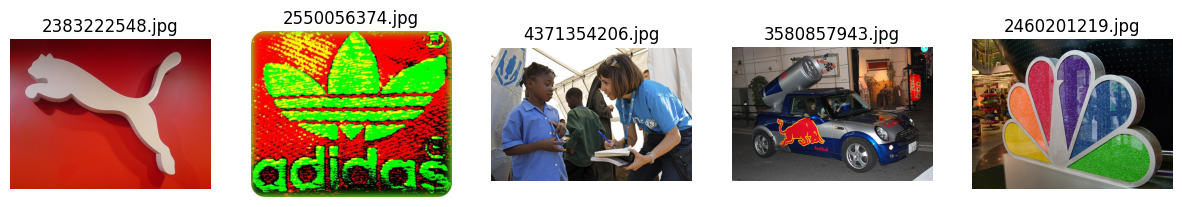

In [5]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample_images)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample_images[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image_file[index])
    plt.axis('off')
plt.show()

### After Cropping

In [6]:
# Initialize lists to hold the cropped images and their labels
sample2 = []
sample_image2 = []

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    
    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]
        
        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']
            cropped_img = img[y1:y2, x1:x2]
            
            sample2.append(cropped_img)
            sample_image2.append(logo)

# Display the number of images and labels
print("Total images: {}".format(len(sample2)))
print("Total labels: {}".format(len(sample_image2)))

Total images: 4536
Total labels: 4536


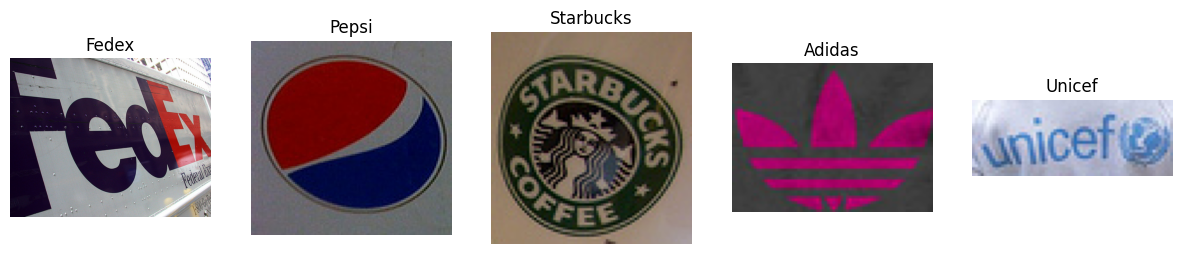

In [7]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample2)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample2[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image2[index])
    plt.axis('off')
plt.show()

### After Cropping Adding PreProcessing

In [8]:
# Initialize lists to hold the cropped images and their labels
X = []
y = []

# Preprocessing functions
def preprocess_image(img):
    try:
        # Calculate padding to make the image square
        h, w = img.shape[:2]
        top, bottom, left, right = 0, 0, 0, 0
        if h > w:
            diff = h - w
            left = diff // 2
            right = diff - left
        else:
            diff = w - h
            top = diff // 2
            bottom = diff - top

        # Apply padding
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Resize to a fixed size (e.g., 224x224)
        img = cv2.resize(img, (224, 224))

        # Normalize pixel values to range [0, 1]
        img = img / 255.0

        return img
    
    except cv2.error as e:
        print(f"Error resizing image: {e}")
        return None

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)

    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]

        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']

            if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
                print(f"Invalid coordinates for image {image}: ({x1}, {y1}, {x2}, {y2})")
                continue

            cropped_img = img[y1:y2, x1:x2]

            if cropped_img.size == 0:
                print(f"Cropped image: {image} is empty for coordinates: ({x1}, {y1}, {x2}, {y2})")
                continue

            processed_img = preprocess_image(cropped_img)
            
            if processed_img is None:
                continue

            X.append(processed_img)
            y.append(logo)

try:
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
except ValueError as e:
    print(f"Error converting lists to arrays: {e}")

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))

Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Total images: 4531
Total labels: 4531


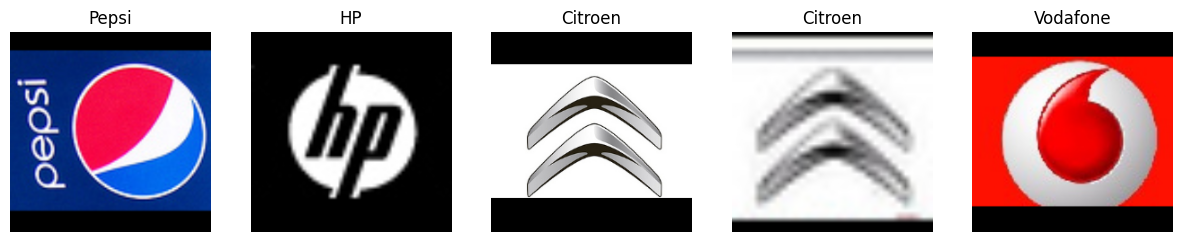

In [9]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB))
    plt.title(y[index])
    plt.axis('off')
plt.show()

## Split Train Test Data

In [10]:
from sklearn.preprocessing import LabelEncoder

X = np.array(X, dtype=np.float32)

y = np.array(y)  

# Use LabelEncoder to convert string labels to integer labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Validation images: {}".format(len(X_val)))
print("Testing images: {}".format(len(X_test)))

Total images: 4531
Total labels: 4531
Training images: 2718
Validation images: 906
Testing images: 907


### Image Augmentation on Trainining Data

In [12]:
aug_train_images = []
aug_train_labels = []

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for index, train_img in enumerate(X_train):
    add_logo = y_train[index]

    expanded_img = np.expand_dims(train_img, axis=0)

    aug_iter = datagen.flow(expanded_img, batch_size=1)
    aug_images = [next(aug_iter)[0].astype(np.float32)]

    for aug_img in aug_images:
        aug_train_images.append(aug_img)
        aug_train_labels.append(add_logo)

aug_train_images = np.array(aug_train_images, dtype=np.float32)
aug_train_labels = np.array(aug_train_labels)

X_train = np.concatenate((X_train, aug_train_images), axis=0)
y_train = np.concatenate((y_train, aug_train_labels), axis=0)

print("Total training images after augmentation: {}".format(len(X_train)))
print("Total training labels after augmentation: {}".format(len(y_train)))

Total training images after augmentation: 5436
Total training labels after augmentation: 5436


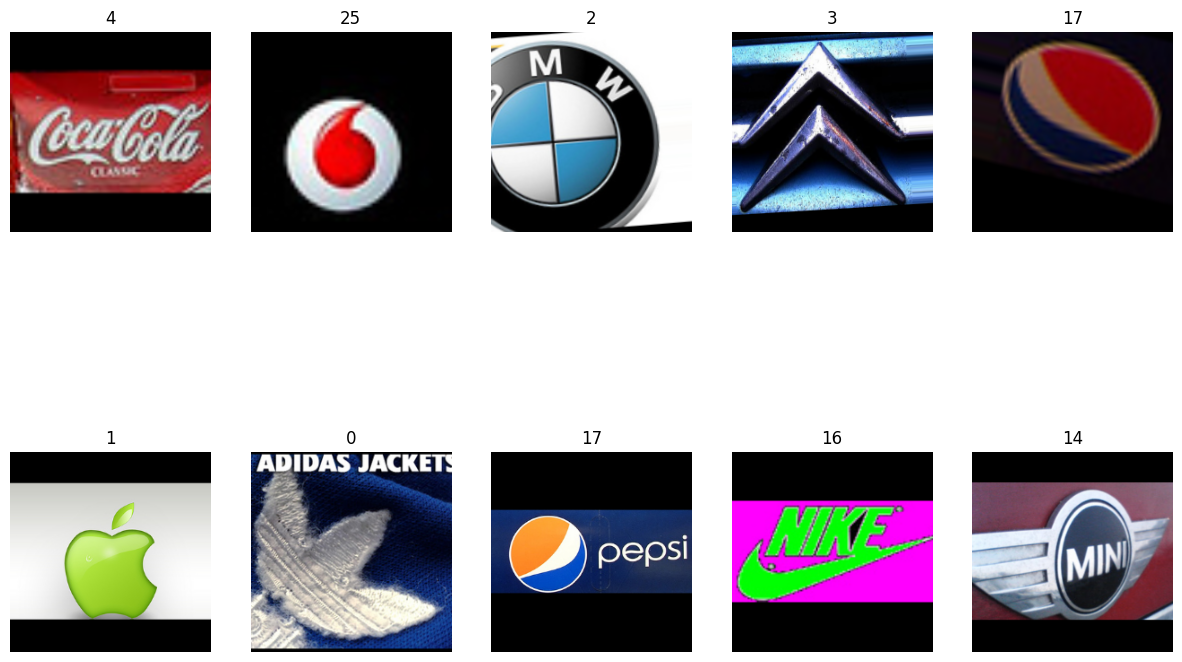

In [13]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X_train)), 10)
for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(X_train[index], cv2.COLOR_BGR2RGB))
    plt.title(y_train[index])
    plt.axis('off')
plt.show()

In [14]:
# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Training labels: {}".format(len(y_train)))
print("Validation images: {}".format(len(X_val)))
print("Validation labels: {}".format(len(y_val)))
print("Testing images: {}".format(len(X_test)))
print("Testing labels: {}".format(len(y_test)))

Total images: 4531
Total labels: 4531
Training images: 5436
Training labels: 5436
Validation images: 906
Validation labels: 906
Testing images: 907
Testing labels: 907


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [16]:
base_layer = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
)

model = Sequential([
    base_layer,
    Flatten(),
    Dense(512,activation="relu"),
    BatchNormalization(),
    Dense(1024,activation="relu"),
    Dropout(0.45),
    BatchNormalization(),
    Dense(2048,activation="relu"),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1024,activation="relu"),
    Dropout(0.35),
    BatchNormalization(),
    Dense(len(y),activation="softmax")
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
from tensorflow.keras import optimizers

model.compile(loss='sparse_categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])

In [18]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 1, verbose = 1, factor = 0.25, mode="min")

In [19]:
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/20


I0000 00:00:1721474813.076612     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721474813.175920     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.4184 - loss: 4.5359

W0000 00:00:1721474929.624953     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4207 - loss: 4.5114   

W0000 00:00:1721474935.634697     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4230 - loss: 4.4875 - val_accuracy: 0.0541 - val_loss: 11.7301 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1721474943.684595     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 55s 652ms/step - accuracy: 0.8625 - loss: 0.5147 - val_accuracy: 0.0861 - val_loss: 5.2168 - learning_rate: 0.0010
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 650ms/step - accuracy: 0.9301 - loss: 0.2575 - val_accuracy: 0.0331 - val_loss: 4.6682 - learning_rate: 0.0010
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9478 - loss: 0.1760
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
85/85 ━━━━━━━━━━━━━━━━━━━━ 54s 636ms/step - accuracy: 0.9479 - loss: 0.1757 - val_accuracy: 0.0541 - val_loss: 6.8434 - learning_rate: 0.0010
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9810 - loss: 0.0657
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
85/85 ━━━━━━━━━━━━━━━━━━━━ 54s 641ms/step - accuracy: 0.9811 - loss: 0.0655 - val_accuracy: 0.0651 - val_loss: 5.5029 - learning_rate: 2.5000e-04
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 55s 641ms/step - accuracy: 0.9963 - loss: 0.0155 - val_a

W0000 00:00:1721476045.035389     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.9888 - loss: 0.0381
Test Accuracy: 99.12%


W0000 00:00:1721476053.377193     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


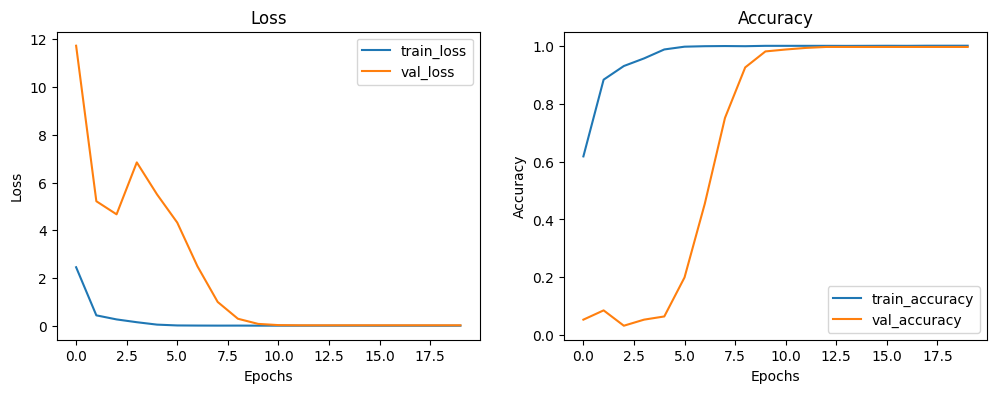

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
model.save('resnet.h5')